In [ ]:
pip install rpy2

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 4.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=5efcda8d1ddd36f8e11916f9985e316fa32911666f0431dc5d65d7197ab8a62c
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
!pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects import r


train_object = r['readRDS']('/content/drive/MyDrive/UROMOL_TaLG.teachingcohort.rds')
# Check structure
print(type(train_object))
print(train_object.rclass)

<class 'rpy2.robjects.vectors.DataFrame'>
<rpy2.rinterface_lib.sexp.StrSexpVector object at 0x7e6f80834110> [16]


In [ ]:
# Load the RDS file
test_object = r['readRDS']('/content/drive/MyDrive/knowles_matched_TaLG_final.rds')
# Check structure
print(type(test_object))
print(test_object.rclass)

<class 'rpy2.robjects.vectors.DataFrame'>
<rpy2.rinterface_lib.sexp.StrSexpVector object at 0x7e6f8082c410> [16]


In [ ]:
#@title load train and test object to pd df
import pandas as pd
import numpy as np
from rpy2.robjects import r

clean_data = {}

#metadata columns (clinical variables)
for colname in test_object.colnames:
    column = test_object.rx2(str(colname))

    # Only keep 1D atomic vectors (int, float, str, bool)
    try:
        if column.nrow == 1:
            continue
    except AttributeError:
        pass

    if len(column.dim) if hasattr(column, 'dim') else 1 > 1:
        print(f"Skipping multi-dimensional column: {colname}")
        continue

    clean_data[colname] = list(column)

# clinical metadata to df
metadata_df = pd.DataFrame(clean_data)
#fill the nan values under RFS_time column with FUtime_days/30 if recurrence is 0
#this is a core assumption made by me to make the external validation dataset plausible
# Fill RFS_time NaNs with FUtime_days / 30 only when Recurrence == 0
metadata_df.loc[metadata_df['RFS_time'].isna() & (metadata_df['Recurrence'] == 0), 'RFS_time'] = metadata_df['FUtime_days.'] / 30
#expression matrix for test data
expression = test_object.rx2("exprs")
gene_names = list(r.colnames(expression))#gene names
# expression to np to df
expression_df = pd.DataFrame(np.array(expression), columns=gene_names)
#add things back
test_df = pd.concat([metadata_df.reset_index(drop=True), expression_df.reset_index(drop=True)], axis=1)

print(test_df.head())

Skipping multi-dimensional column: exprs
   Progression  PFS_time.  Recurrence  RFS_time  FUtime_days.  Age Sex  \
0            0        NaN           1       5.0          4110   64   F   
1            0        NaN           1      14.0           840   33   F   
2            0        NaN           0      61.0          1830   59   M   
3            0        NaN           0     122.0          3660   28   M   
4            0        NaN           1      11.0          2010   70   M   

  Tumor.stage Tumor.grade Concomitant.CIS  ...      F8A1     H2AC18  \
0          Ta         Low              No  ...  7.659416   9.883299   
1          Ta         Low              No  ...  7.840158  10.470182   
2          Ta         Low              No  ...  7.601279  10.991997   
3          Ta         Low              No  ...  7.930296   9.258743   
4          Ta         Low              No  ...  8.274731  11.221522   

      H2AC19   PPIAL4C   PPIAL4D      TARP  GUCA1ANB-GUCA1A     HOMEZ  \
0   9.883299  

In [ ]:
metadata_df.columns

Index(['Progression', 'PFS_time.', 'Recurrence', 'RFS_time', 'FUtime_days.',
       'Age', 'Sex', 'Tumor.stage', 'Tumor.grade', 'Concomitant.CIS', 'BCG',
       'UROMOL2021.classification', 'knowles_ID'],
      dtype='object')

In [ ]:
#same process on the training data

clean_data = {}

#
for colname in train_object.colnames:
    column = train_object.rx2(str(colname))
    try:
        if column.nrow == 1:
            continue
    except AttributeError:
        pass

    if len(column.dim) if hasattr(column, 'dim') else 1 > 1:
        print(f"Skipping multi-dimensional column: {colname}")
        continue

    clean_data[colname] = list(column)

metadata_df = pd.DataFrame(clean_data)
expression = train_object.rx2("exprs")
gene_names = list(r.colnames(expression))
expression_df = pd.DataFrame(np.array(expression), columns=gene_names)
train_df = pd.concat([metadata_df.reset_index(drop=True), expression_df.reset_index(drop=True)], axis=1)
print(train_df.head())




Skipping multi-dimensional column: exprs
  UROMOL.ID  Progression  PFS_time.  Recurrence  RFS_time  FUtime_days.  Age  \
0     U0001            0      82.40           1     32.73          2472   86   
1     U0002            0      72.10           1      4.97          2163   73   
2     U0007            0      62.20           1     12.83          1866   66   
3     U0010            0      40.63           1      4.33          1219   76   
4     U0012            0      62.00           0     62.00          1860   83   

  Sex  Smoking Tumor.stage  ...   KIR3DL1    CDY15P   VN1R88P  REXO1L9P  \
0   M    Never          Ta  ... -3.741143 -3.741143 -3.741143 -3.741143   
1   M   Former          Ta  ... -3.741143 -3.741143 -3.741143 -3.741143   
2   M  Current          Ta  ... -3.741143 -3.741143 -3.741143 -3.741143   
3   M  Current          Ta  ... -3.741143 -3.741143 -3.741143 -3.741143   
4   F    Never          Ta  ... -3.741143 -3.741143 -3.741143 -3.741143   

    CYCSP12    KRT43P RNU6-

In [ ]:
metadata_df.columns

Index(['UROMOL.ID', 'Progression', 'PFS_time.', 'Recurrence', 'RFS_time',
       'FUtime_days.', 'Age', 'Sex', 'Smoking', 'Tumor.stage', 'Tumor.grade',
       'Concomitant.CIS', 'Tumor.size', 'Incident.tumor', 'EAU.risk', 'BCG',
       'UROMOL2021.classification'],
      dtype='object')

In [ ]:
metadata_df

,UROMOL.ID,Progression,PFS_time.,Recurrence,RFS_time,FUtime_days.,Age,Sex,Smoking,Tumor.stage,Tumor.grade,Concomitant.CIS,Tumor.size,Incident.tumor,EAU.risk,BCG,UROMOL2021.classification
0,U0001,0,82.40,1,32.73,2472,86,M,Never,Ta,Low grade,No,< 3 cm,No,Intermediate,0,Class 1
1,U0002,0,72.10,1,4.97,2163,73,M,Former,Ta,Low grade,No,< 3 cm,No,Intermediate,0,Class 2b
2,U0007,0,62.20,1,12.83,1866,66,M,Current,Ta,Low grade,Yes,< 3 cm,No,High,1,Class 1
3,U0010,0,40.63,1,4.33,1219,76,M,Current,Ta,Low grade,No,< 3 cm,No,Intermediate,0,Class 2b
4,U0012,0,62.00,0,62.00,1860,83,F,Never,Ta,Low grade,No,< 3 cm,No,Intermediate,0,Class 2a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,U2116,0,161.13,1,13.30,4834,59,F,NA_character_,Ta,Low grade,No,< 3 cm,No,Intermediate,1,Class 3
282,U2117,0,27.00,1,6.30,810,61,M,NA_character_,Ta,Low grade,No,< 3 cm,Yes,Intermediate,1,Class 2a
283,U2118,0,141.00,1,4.17,4230,60,F,NA_character_,Ta,Low grade,No,< 3 cm,No,Intermediate,1,Class 2b
284,U2120,0,46.73,1,9.37,1402,52,F,NA_character_,Ta,Low grade,No,< 3 cm,No,Intermediate,1,Class 2a


In [ ]:
#@title drop columns
#remove progression feature to prevent data leakage
test_df= test_df.drop(columns=["knowles_ID","Progression", "PFS_time.",'FUtime_days.'])
train_df= train_df.drop(columns=["UROMOL.ID","Progression", "PFS_time.",'FUtime_days.'])

In [ ]:
#overalpping varibles
#common columns in intersection
common_cols = train_df.columns.intersection(test_df.columns)

# keep only those columns
train_df = train_df[common_cols]
test_df = test_df[common_cols]


In [ ]:
#only keep 0/1 recurrence
#drop the other ones ()
test_df = test_df[test_df["Recurrence"].isin([0, 1])]
train_df = train_df[train_df["Recurrence"].isin([0, 1])]

In [ ]:
len(test_df[test_df['RFS_time'].isnull()]) #49 empty rfs value
#test_df['RFS_time'].notna().sum()#28 non empty rfs value --> 77 values in total
#--> can't do survival analysis with the problematic RFS time variable in the testign set

test_df = test_df.dropna(subset=['RFS_time'])
test_df

,Recurrence,RFS_time,Age,Sex,Tumor.stage,Tumor.grade,Concomitant.CIS,BCG,UROMOL2021.classification,B2M,...,BSX,LINC01365,TARM1,LCE2B,TSPY1,SPO11,KIRREL3-AS2,KIR2DS4,MAS1L,KIR3DL1
0,1,5.0,64,F,Ta,Low,No,0,Class_1,14.717812,...,4.454749,5.203753,5.920625,5.028319,4.458005,4.251453,3.750147,4.291886,4.077035,4.343596
1,1,14.0,33,F,Ta,Low,No,0,Class_1,14.753362,...,4.404597,4.959406,5.344095,5.563745,4.326024,3.813312,3.799209,4.342703,4.412858,4.252083
2,0,61.0,59,M,Ta,Low,No,0,Class_1,14.610970,...,4.599752,4.889477,5.486404,5.827896,4.298763,3.977789,3.754768,4.254193,4.781268,4.219368
3,0,122.0,28,M,Ta,Low,No,0,Class_1,14.673840,...,4.305061,4.752156,5.556437,6.351382,4.428139,4.223701,3.603547,4.299421,4.330310,4.238222
4,1,11.0,70,M,Ta,Low,No,0,Class_2b,15.148027,...,4.405568,5.152060,5.433964,5.295300,4.442787,4.070764,4.013255,4.462838,4.525418,4.438879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0,70.0,84,M,Ta,Low,No,0,Class_1,15.258108,...,4.394270,4.855167,5.170959,5.159802,4.314262,3.925930,4.177083,4.249706,4.536612,4.241476
73,0,32.0,67,F,Ta,Low,No,0,Class_1,14.965824,...,4.311049,5.102102,5.400698,4.908097,4.426006,3.928472,3.651292,4.318996,3.814298,4.285784
74,0,29.0,60,F,Ta,Low,No,0,Class_1,14.612196,...,4.434437,4.793628,5.633449,5.505902,4.529299,3.825766,3.728245,4.257967,4.513070,4.299200
75,0,34.0,68,F,Ta,Low,No,0,Class_1,14.603370,...,4.219373,4.734053,5.581352,6.954751,4.589194,4.074799,4.117908,4.340189,4.519989,4.339056


In [ ]:
!pip install --quiet scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
#@title select highly variable genes
#import scanpy as sc
#import anndata as ad


clinical_vars = [
    'Recurrence','RFS_time',
    'Age', 'Sex', 'Tumor.stage', 'Tumor.grade', 'Concomitant.CIS', 'BCG',
    'UROMOL2021.classification'
]#'PFS_time.',--> not including it in clinical variabels 'FUtime_days.',

# expression data
expression_df = train_df.drop(columns=clinical_vars)
'''
#AnnData
adata = ad.AnnData(X=expression_df.values)
adata.var_names = expression_df.columns
adata.obs_names = train_df.index.astype(str)

# hgv
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=1)
top_genes = adata.var[adata.var['highly_variable']].index.tolist()
'''
# Variance-based filtering
expression_only = train_df.drop(columns=clinical_vars)
gene_variances = expression_only.var()
top_genes = gene_variances.sort_values(ascending=False).head(5).index.tolist()

#by top HVGs
train_df_filtered = pd.concat([train_df[clinical_vars], train_df[top_genes]], axis=1)
test_df_filtered = pd.concat([test_df[clinical_vars], test_df[top_genes]], axis=1)


In [ ]:
train_df_filtered.head(20)

,Recurrence,RFS_time,Age,Sex,Tumor.stage,Tumor.grade,Concomitant.CIS,BCG,UROMOL2021.classification,GSTM1,HSPA1A,IGF2,EIF3CL,HLA-DRB5
0,1,32.73,86,M,Ta,Low grade,No,0,Class 1,8.929858,7.940887,11.826868,7.441688,-3.741143
1,1,4.97,73,M,Ta,Low grade,No,0,Class 2b,8.262064,-3.741143,10.565273,6.731815,5.678747
2,1,12.83,66,M,Ta,Low grade,Yes,1,Class 1,-0.023091,-3.741142,10.902505,6.839314,-2.538942
3,1,4.33,76,M,Ta,Low grade,No,0,Class 2b,7.819437,6.135151,6.131452,-3.741143,-3.741143
4,0,62.00,83,F,Ta,Low grade,No,0,Class 2a,8.538216,6.878101,-0.674129,-3.679096,2.676963
5,1,15.50,71,M,Ta,Low grade,No,0,Class 2b,10.001080,6.996222,3.339905,4.545583,-2.107022
6,1,31.83,59,M,Ta,Low grade,No,0,Class 1,9.029805,-3.741143,4.831993,6.655304,7.636098
7,0,81.70,77,F,Ta,Low grade,No,0,Class 1,-0.004880,0.210020,9.599292,-3.741143,6.917272
8,1,4.77,81,F,Ta,Low grade,No,0,Class 1,1.648027,0.552933,6.178982,5.809489,4.349853
9,1,60.90,64,M,Ta,Low grade,No,0,Class 1,3.993332,7.244115,-0.216907,-3.738958,-0.371242


In [ ]:
test_df_filtered

,Recurrence,RFS_time,Age,Sex,Tumor.stage,Tumor.grade,Concomitant.CIS,BCG,UROMOL2021.classification,GSTM1,HSPA1A,IGF2,EIF3CL,HLA-DRB5
0,1,5.0,64,F,Ta,Low,No,0,Class_1,13.178860,10.728666,5.819765,14.472255,6.450760
1,1,14.0,33,F,Ta,Low,No,0,Class_1,13.341340,11.558671,6.073195,14.379310,11.314080
2,0,61.0,59,M,Ta,Low,No,0,Class_1,9.302856,11.229165,5.316560,14.780700,9.076220
3,0,122.0,28,M,Ta,Low,No,0,Class_1,6.674160,11.337702,7.084960,14.225800,12.043030
4,1,11.0,70,M,Ta,Low,No,0,Class_2b,6.383024,9.448853,5.799897,13.838090,9.693255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0,70.0,84,M,Ta,Low,No,0,Class_1,6.104260,11.310214,5.304839,14.458765,7.167300
73,0,32.0,67,F,Ta,Low,No,0,Class_1,12.902710,11.437647,5.314489,14.766585,13.425260
74,0,29.0,60,F,Ta,Low,No,0,Class_1,6.736081,11.067221,5.587941,13.365850,6.701504
75,0,34.0,68,F,Ta,Low,No,0,Class_1,9.574966,9.805158,7.842695,14.353580,6.850331


<lifelines.CoxPHFitter: fitted with 276 total observations, 86 right-censored observations>
             duration col = 'RFS_time'
                event col = 'Recurrence'
      baseline estimation = breslow
   number of observations = 276
number of events observed = 190
   partial log-likelihood = -929.26
         time fit was run = 2025-03-30 05:18:30 UTC

---
                                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                
cat__Sex_M                              -0.33      0.72      0.17           -0.67            0.00                0.51                1.00
cat__Concomitant.CIS_Yes                 0.42      1.53      0.23           -0.03            0.88                0.97                2.40
cat__UROMOL2021.classification_Class 2a  0.30      1.35      0.25           -0.20            0.80                0.82                2.23
cat__UROMOL2021.classification_Class 2b  0.44      1.56      0.20            0.05            0.84                1.05                2.32
cat__UROMOL2021.classification_Class 3   0.27      1.31      0.23           -0.17            0.71                0.84                2.04
remainder__Age                           0.00      1.00      0.00           -0.00            0.00                1.00                1.00
remainder__BCG                           0.53      1.71      0.18            0.17            0.90                1.19                2.45
remainder__GSTM1                         0.04      1.04      0.02            0.00            0.07                1.00                1.08
remainder__HSPA1A                        0.02      1.02      0.02           -0.02            0.06                0.99                1.06
remainder__IGF2                          0.02      1.02      0.02           -0.02            0.06                0.98                1.06
remainder__EIF3CL                        0.03      1.03      0.02           -0.01            0.07                0.99                1.08
remainder__HLA-DRB5                     -0.00      1.00      0.02           -0.04            0.04                0.96                1.04

                                         cmp to     z      p  -log2(p)
covariate                                                             
cat__Sex_M                                 0.00 -1.94   0.05      4.27
cat__Concomitant.CIS_Yes                   0.00  1.84   0.07      3.92
cat__UROMOL2021.classification_Class 2a    0.00  1.19   0.23      2.10
cat__UROMOL2021.classification_Class 2b    0.00  2.20   0.03      5.17
cat__UROMOL2021.classification_Class 3     0.00  1.19   0.23      2.10
remainder__Age                             0.00  1.36   0.17      2.52
remainder__BCG                             0.00  2.89 <0.005      8.02
remainder__GSTM1                           0.00  2.23   0.03      5.27
remainder__HSPA1A                          0.00  1.18   0.24      2.06
remainder__IGF2                            0.00  0.98   0.32      1.62
remainder__EIF3CL                          0.00  1.59   0.11      3.16
remainder__HLA-DRB5                        0.00 -0.01   0.99      0.01
---
Concordance = 0.64
Partial AIC = 1882.52
log-likelihood ratio test = 42.61 on 12 df
-log2(p) of ll-ratio test = 15.21

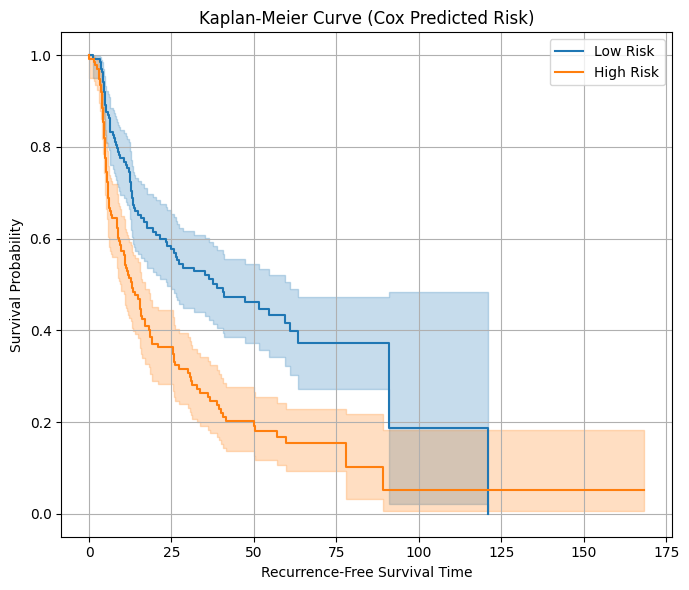

Log-rank p-value: 1.4655e-06
C-index: 0.644


In [ ]:
#@title use Lifelines cox regression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#target and features
target_cols = ['Recurrence', 'RFS_time']
df = train_df_filtered[train_df_filtered['Recurrence'].isin([0, 1])]
X = df.drop(columns=target_cols)
y_event = df['Recurrence'].astype(int)
y_time = df['RFS_time']
# encode categorical features ---
categorical_features = X.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

X_encoded = preprocessor.fit_transform(X)
X_encoded_df = pd.DataFrame(
    X_encoded.toarray() if hasattr(X_encoded, "toarray") else X_encoded,
    columns=preprocessor.get_feature_names_out(),
    index=df.index
)

#survival taregt
cox_df = X_encoded_df.copy()
cox_df["RFS_time"] = y_time.values
cox_df["Recurrence"] = y_event.values
################
cph = CoxPHFitter()
cph.fit(cox_df, duration_col="RFS_time", event_col="Recurrence")
cph.print_summary()

# risk score
cox_df["risk_score"] = cph.predict_partial_hazard(cox_df)

#stratify into risk groups by median
median_risk = cox_df["risk_score"].median()
cox_df["risk_group"] = (cox_df["risk_score"] >= median_risk).astype(int)

# KM curve
kmf = KaplanMeierFitter()
plt.figure(figsize=(7, 6))
for group in [0, 1]:
    label = "High Risk" if group == 1 else "Low Risk"
    mask = cox_df["risk_group"] == group
    kmf.fit(cox_df.loc[mask, "RFS_time"], cox_df.loc[mask, "Recurrence"], label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Curve (Cox Predicted Risk)")
plt.xlabel("Recurrence-Free Survival Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

# log rank test
group0 = cox_df[cox_df["risk_group"] == 0]
group1 = cox_df[cox_df["risk_group"] == 1]
results = logrank_test(
    group0["RFS_time"], group1["RFS_time"],
    event_observed_A=group0["Recurrence"],
    event_observed_B=group1["Recurrence"]
)
print(f"Log-rank p-value: {results.p_value:.4e}")

#c index
c_index = concordance_index(
    cox_df["RFS_time"],
    -cox_df["risk_score"],  # higher score = worse outcome
    cox_df["Recurrence"]
)
print(f"C-index: {c_index:.3f}")






/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


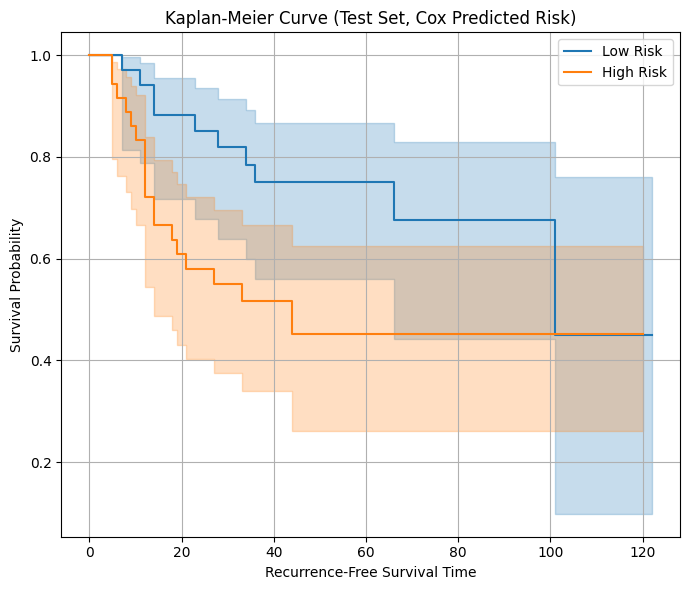

Log-rank p-value (Test Set): 2.3188e-02
C-index (Test Set): 0.648


In [ ]:
#@title on the external validation data
###reuse
X_test = test_df_filtered.drop(columns=["Recurrence", "RFS_time"], errors="ignore")
y_test_event = test_df_filtered["Recurrence"].astype(int)
y_test_time = test_df_filtered["RFS_time"]
X_test_encoded = preprocessor.transform(X_test)
X_test_encoded_df = pd.DataFrame(
    X_test_encoded.toarray() if hasattr(X_test_encoded, "toarray") else X_test_encoded,
    columns=preprocessor.get_feature_names_out(),
    index=test_df_filtered.index
)

#risk score
cox_test_input = X_test_encoded_df.copy()
cox_test_input["RFS_time"] = y_test_time.values
cox_test_input["Recurrence"] = y_test_event.values
cox_test_input["risk_score"] = cph.predict_partial_hazard(cox_test_input)

#stratify
median_risk_test = cox_test_input["risk_score"].median()
cox_test_input["risk_group"] = (cox_test_input["risk_score"] >= median_risk_test).astype(int)

# km
kmf = KaplanMeierFitter()
plt.figure(figsize=(7, 6))
for group in [0, 1]:
    label = "High Risk" if group == 1 else "Low Risk"
    mask = cox_test_input["risk_group"] == group
    kmf.fit(cox_test_input.loc[mask, "RFS_time"], cox_test_input.loc[mask, "Recurrence"], label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Curve (Test Set, Cox Predicted Risk)")
plt.xlabel("Recurrence-Free Survival Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

# log rank
group0 = cox_test_input[cox_test_input["risk_group"] == 0]
group1 = cox_test_input[cox_test_input["risk_group"] == 1]
results = logrank_test(
    group0["RFS_time"], group1["RFS_time"],
    event_observed_A=group0["Recurrence"],
    event_observed_B=group1["Recurrence"]
)
print(f"Log-rank p-value (Test Set): {results.p_value:.4e}")

#c index
c_index_test = concordance_index(
    cox_test_input["RFS_time"],
    -cox_test_input["risk_score"],  # higher score = higher risk
    cox_test_input["Recurrence"]
)
print(f"C-index (Test Set): {c_index_test:.3f}")


In [ ]:
import seaborn as sns

# Get coefficients and hazard ratios
summary_df = cph.summary.reset_index()
summary_df


,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,cat__Sex_M,-3.342881e-01,0.715848,1.720111e-01,-6.714236e-01,2.847508e-03,0.510981,1.002852,0.0,-1.943410,0.051967,4.266270
1,cat__Concomitant.CIS_Yes,4.236576e-01,1.527539,2.303929e-01,-2.790411e-02,8.752194e-01,0.972482,2.399402,0.0,1.838849,0.065937,3.922758
2,cat__UROMOL2021.classification_Class 2a,3.032828e-01,1.354297,2.548174e-01,-1.961502e-01,8.027158e-01,0.821889,2.231593,0.0,1.190197,0.233969,2.095610
3,cat__UROMOL2021.classification_Class 2b,4.440939e-01,1.559077,2.017089e-01,4.875178e-02,8.394360e-01,1.049960,2.315061,0.0,2.201658,0.027689,5.174518
4,cat__UROMOL2021.classification_Class 3,2.695415e-01,1.309364,2.259619e-01,-1.733356e-01,7.124186e-01,0.840855,2.038917,0.0,1.192863,0.232923,2.102074
5,remainder__Age,4.633663e-10,1.000000,3.415721e-10,-2.061027e-10,1.132835e-09,1.000000,1.000000,0.0,1.356570,0.174918,2.515249
6,remainder__BCG,5.342903e-01,1.706237,1.848089e-01,1.720715e-01,8.965091e-01,1.187763,2.451032,0.0,2.891042,0.003840,8.024804
7,remainder__GSTM1,3.974668e-02,1.040547,1.784195e-02,4.777101e-03,7.471626e-02,1.004789,1.077578,0.0,2.227709,0.025900,5.270910
8,remainder__HSPA1A,2.258241e-02,1.022839,1.921398e-02,-1.507630e-02,6.024111e-02,0.985037,1.062093,0.0,1.175311,0.239870,2.059674
9,remainder__IGF2,2.072480e-02,1.020941,2.105510e-02,-2.054244e-02,6.199204e-02,0.979667,1.063954,0.0,0.984312,0.324962,1.621657


<ipython-input-23-a81b1d8d67c6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


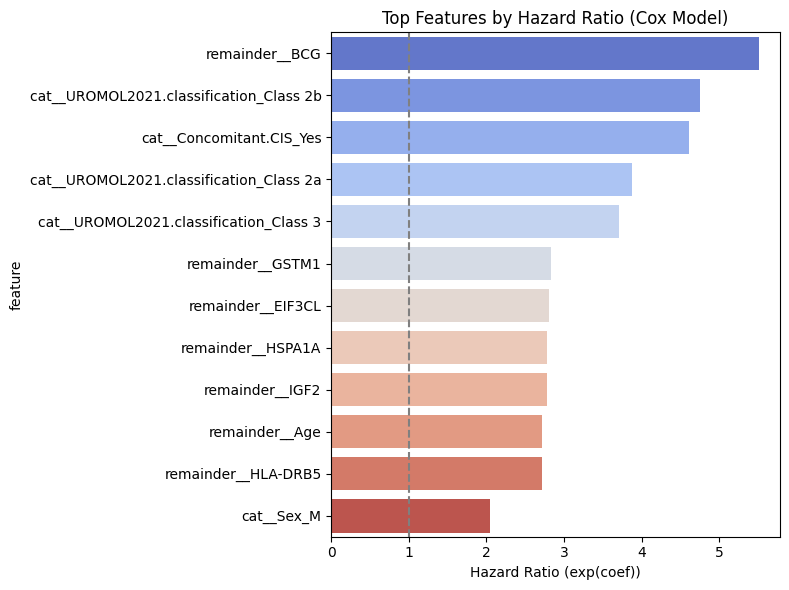

In [ ]:
summary_df['feature'] = summary_df['covariate']
summary_df['HR'] = np.exp(summary_df['exp(coef)'])

# Sort by absolute value of coefficients (importance)
summary_df = summary_df.sort_values(by='exp(coef)', key=np.abs, ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(
    data=summary_df.head(20),  # Top 20 features
    y='feature',
    x='HR',
    orient='h',
    palette='coolwarm',
)
plt.axvline(x=1, color='gray', linestyle='--')
plt.xlabel("Hazard Ratio (exp(coef))")
plt.title("Top Features by Hazard Ratio (Cox Model)")
plt.tight_layout()
plt.show()


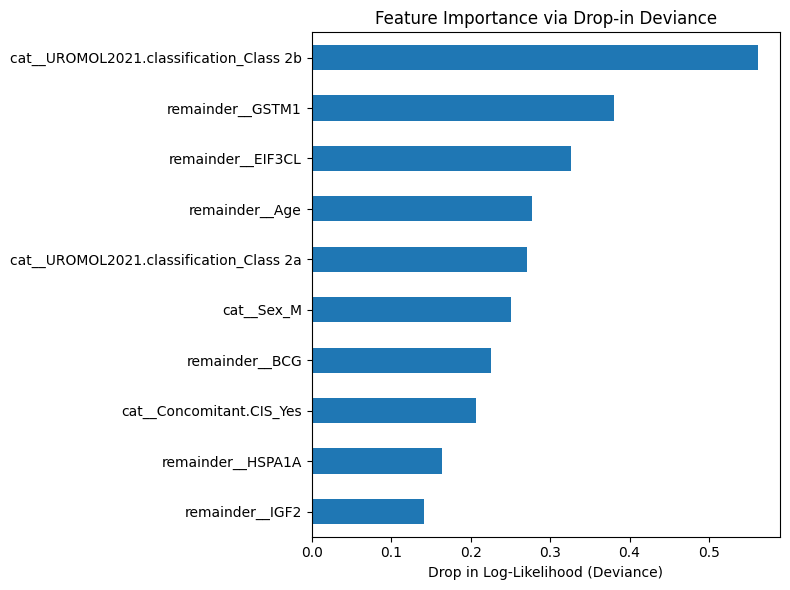

In [ ]:
#@title feature importance
full_ll = cph.log_likelihood_
drop_scores = {}

#loop through all features
feature_cols = cox_df.drop(columns=["RFS_time", "Recurrence"]).columns

for feature in feature_cols:
    try:
        df_reduced = cox_df.drop(columns=[feature])
        cph_reduced = CoxPHFitter()
        cph_reduced.fit(df_reduced, duration_col="RFS_time", event_col="Recurrence")
        drop_ll = cph_reduced.log_likelihood_
        drop_scores[feature] = full_ll - drop_ll
    except Exception as e:
        print(f"Skipping {feature}: {e}")

#sort by score
importance_df = pd.DataFrame.from_dict(drop_scores, orient='index', columns=['DropInDeviance'])
importance_df = importance_df.sort_values(by='DropInDeviance', ascending=False)

####
importance_df.head(10).plot(kind='barh', figsize=(8, 6), legend=False)
plt.xlabel("Drop in Log-Likelihood (Deviance)")
plt.title("Feature Importance via Drop-in Deviance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
#@title scritp